# Draw a track map with numbered corners

Use the position data of a single lap to draw a track map.
Then annotate the map with corner numbers.


Import FastF1 and load the data. Use the telemetry from the fastest for the
track map. (You could also use any other lap instead.)



In [1]:
import matplotlib.pyplot as plt
import numpy as np

import fastf1


session = fastf1.get_session(2023, 'Silverstone', 'Q')
session.load()

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

circuit_info = session.get_circuit_info()

req         WARNING 	DEFAULT CACHE ENABLED! (55.6 MB) /home/rylei/.cache/fastf1
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '55', '63', '44', '23', '14', '10', '27', '18', '31', '2', '77', '11', '22', '24', '21', '20']


Define a helper function for rotating points around the origin of the
coordinate system.

The matrix ``[[cos, sin], [-sin, cos]]`` is called a rotation matrix.

By matrix multiplication of the rotation matrix with a vector [x, y], a new
rotated vector [x_rot, y_rot] is obtained.
(See also: https://en.wikipedia.org/wiki/Rotation_matrix)



In [2]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

Get the coordinates of the track map from the telemetry of the lap and
rotate the coordinates using the rotation from ``circuit_info`` so that
the track map is oriented correctly. After that, plot the rotated track map.



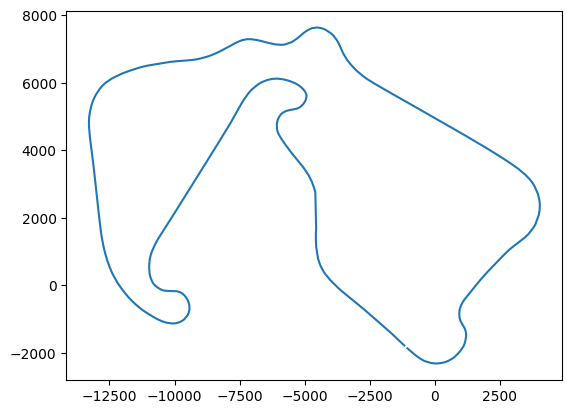

In [3]:
# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

Finally, the corner markers are plotted. To plot the numbers next to the
track, an offset vector that points straight up is defined. This offset
vector is then rotated by the angle that is given for each corner marker.
A line and circular bubble are drawn and the corner marker text is printed
inside the bubble.



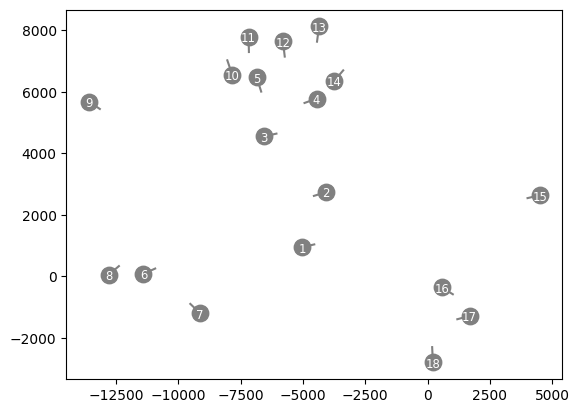

In [4]:
offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')

Add a title, remove tick labels to clean up the plot, set equal axis ratio,
so that the track is not distorted and show the plot.



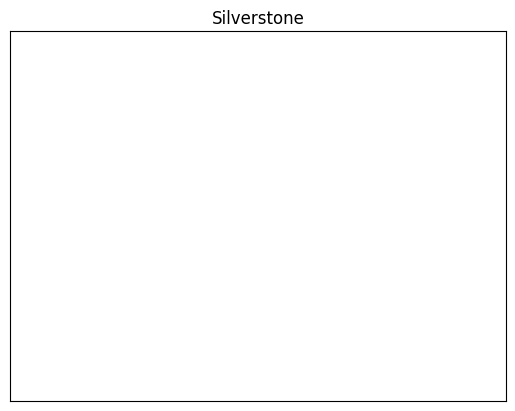

In [5]:
plt.title(session.event['Location'])
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()